In [19]:
# 코랩 환경일 경우 실행
# 한글 깨짐 방지 코드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconf

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import os
from glob import glob
import random
import math

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

# 데이터 준비
### 데이터셋 폴더 관리 방법들
- 학습을 시작하기 전에 데이터셋을 관리하는 여러 방법들에 대해 살펴보겠음.
- 데이터셋을 관리하는 방법에는 여러 방법들이 존재하겠지만 내가 경험한 3가지 방법에 대해 설명하겠음.
- 방법1
  - Train/Valid/Test 폴더를 생성(생성하지 않고 다음 과정을 진행해도 무방함.)
  - Train/Valid/Test 폴더의 하위 폴더에 label 이름을 가지는 폴더를 생성.
  - label 폴더 내부에 label에 해당하는 데이터 저장(이름의 형식은 상관없음.)
  - 데이터의 파일 경로를 저장하여 데이터 로딩 시 사용.
  - 데이터 폴더명을 변수에 저장하여 label 이름으로 사용.
  - label 개수만큼 one-hot 형식의 target 정보를 생성.

- 방법2
  - Train/Valid/Test 폴더를 생성(생성하지 않고 다음 과정을 진행해도 무방함.)
  - Train/Valid/Test 폴더에 "index_label이름.확장자" 형식의 데이터 저장.
  - 예시 : 0_dog, 1_cat, 2_horse, ..., 100_bird.png
  - 데이터의 파일 경로를 저장하여 데이터 로딩 시 사용.
  - 데이터 로딩 과정에서 split 함수를 이용하여 데이터의 이름에서 label 이름을 분리하여 one-hot 형식의 target 정보를 생성.
  - 모든 데이터를 불러와야만 데이터 내부에 어떤 class 들이 존재하는지 알 수 있기 때문에 데이터 규모가 커지면 시간이 소요됨. 따라서 폴더 외부에 class 명을 따로 텍스트 파일로 저장.

- 방법3
  - Train/Valid/Test 폴더를 생성(생성하지 않고 다음 과정을 진행해도 무방함.)
  - Train/Valid/Test 폴더에 "index.확장자" 형식의 데이터 저장.
  - 예시 : 0, 1, 2, ..., 100.png
  - 데이터의 파일 경로를 저장하여 데이터 로딩 시 사용.
  - 폴더 외부에 데이터 관련 정보를 텍스트 파일로 저장.
  - 텍스트 파일 예시 : index, label, 필요 시 정보 추가 가능
  - 0, 1
  - 1, 9
  - 2, 5  
  .  
  .  
  .  
  - 100, 2
- 이번 exploration에서는 방법1로 제공된 데이터셋을 방법3에 맞게 변형하여 학습을 진행하도록 하겠음.

### 데이터셋 로딩
- 데이터셋 로딩은 반복 작업이기 때문에 관련된 함수를 작성함.
- 데이터셋 로딩 시 데이터셋이 비정제 데이터일 경우를 감안하여 간략한 EDA 작업을 수행하겠음.
  - class의 종류 및 개수 파악
  - class별 데이터 개수 편향 방지를 위한 class 별 데이터 개수 파악
  - 이미지 shape이 통일되지 않은 데이터일 경우를 대비한 이미지 shape 분포 파악
  - 각각의 class가 어떠한 이미지들로 구성되어 있는지 파악하기 위한 랜덤 샘플 시각화

### 데이터 분석
- kaggle 학습용 데이터셋 사용
- 데이터는 가위, 바위, 보에 클래스로 이루어져있으며 데이터 수, 모양 등에서 편향이 없음.
- 실제 사람의 손이 아닌 게임 시뮬레이션 화면을 사용한 듯 함.
- 이미지는 흰 배경이고 손목을 포함한 손이 화면 중앙에 위치함. 손의 사이즈에 따라서 손목이 안보이기도 함.
- 손은 기본적으로 손등이 노출된 형태이며 손등의 각도는 약간씩 틀어져있음.
- 손가락의 길이, 피부색, 손톱색 등에서 데이터가 차이가 있음.
- 가위, 바위, 보의 모양에 차이가 있음.

In [ ]:
# # 한글 폰트 깨짐 방지 코드
# # 로컬일 경우 실행
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

In [ ]:
# 방법1
def load_dataset(img_dir, img_present_num=100, column_len=4):
    label_names = os.listdir(img_dir)
    print("label 종류 : {0}".format(label_names))
    print("label 개수 : {0} 개".format(len(label_names)))
    print("\n")

    dataset_nums = []
    for label_name in label_names:
        data_per_class = os.listdir(os.path.join(img_dir, label_name))
        print("{0} 클래스 데이터 개수 : {1} 개".format(label_name, len(data_per_class)))
        dataset_nums.append(len(data_per_class))

    plt.bar(label_names, dataset_nums)
    plt.title("클래스 별 데이터 개수")
    plt.show()

    heights, widths, channels = [], [], []
    img_paths = []
    for label_name in label_names:
        img_path = glob(os.path.join(img_dir, label_name, "*.png"))
        img_paths.extend(img_path)
    
    for img_path in tqdm_notebook(img_paths):
        image = Image.open(img_path)
        image = np.array(image)
        h, w, c = image.shape
        heights.append(h)
        widths.append(w)
        channels.append(c)

    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.hist(heights)
    plt.title("Heights")
    plt.subplot(132)
    plt.hist(widths)
    plt.title("Widths")
    plt.subplot(133)
    plt.hist(channels)
    plt.title("Channels")
    plt.show()

    for label_name in label_names:
        img_per_class = glob(os.path.join(img_dir, label_name, "*.png"))
        img_present_list = random.sample(img_per_class, img_present_num)

        # column_len = 4
        row_len = math.ceil(len(img_present_list) / column_len)

        i, j = 0, 0
        fig, ax = plt.subplots(row_len, column_len, figsize=(20, 4*row_len))
        for idx, img_path in enumerate(img_present_list):
            plt.subplot(row_len, column_len, idx+1)
            image = Image.open(img_path)
            image = np.array(image)
            ax[i, j].imshow(image)
            j += 1
            if j == column_len:
                i += 1
                j = 0

In [ ]:
!ls '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/data/kaggle_data'

paper  rock  scissors


label 종류 : ['paper', 'rock', 'scissors']
label 개수 : 3 개


paper 클래스 데이터 개수 : 964 개
rock 클래스 데이터 개수 : 964 개
scissors 클래스 데이터 개수 : 964 개


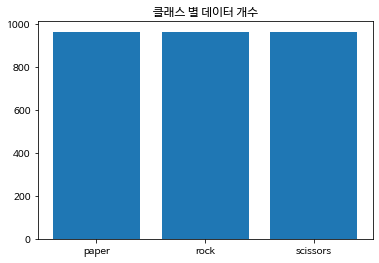

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2892 [00:00<?, ?it/s]

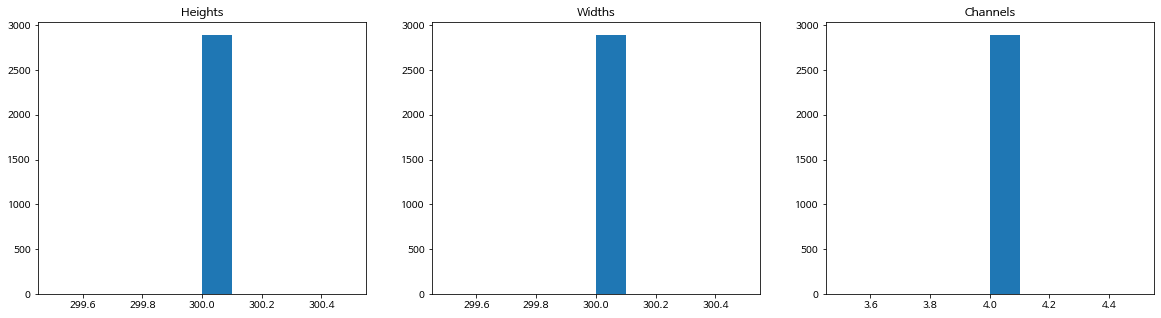

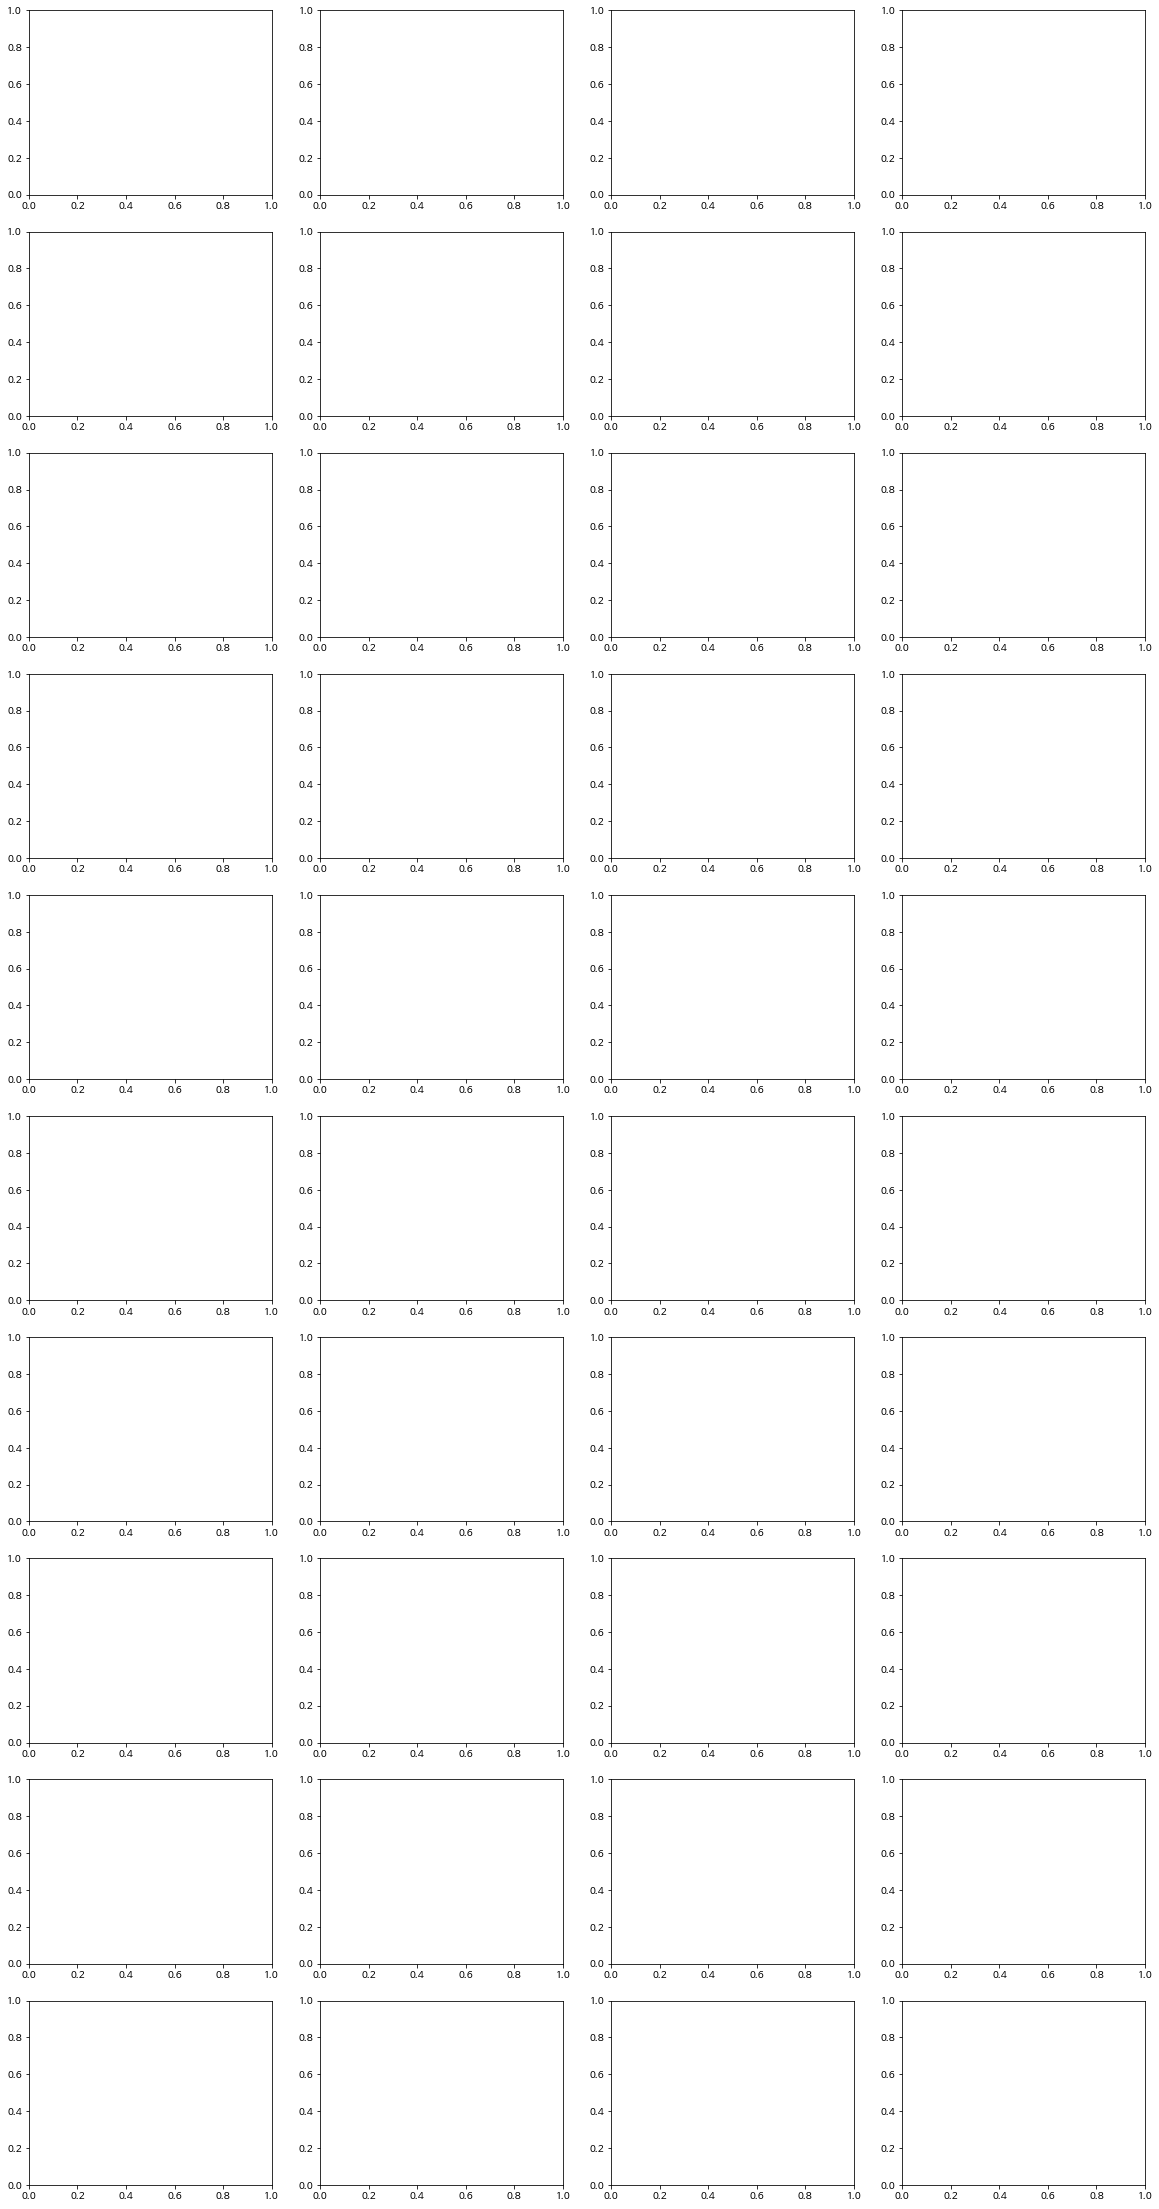

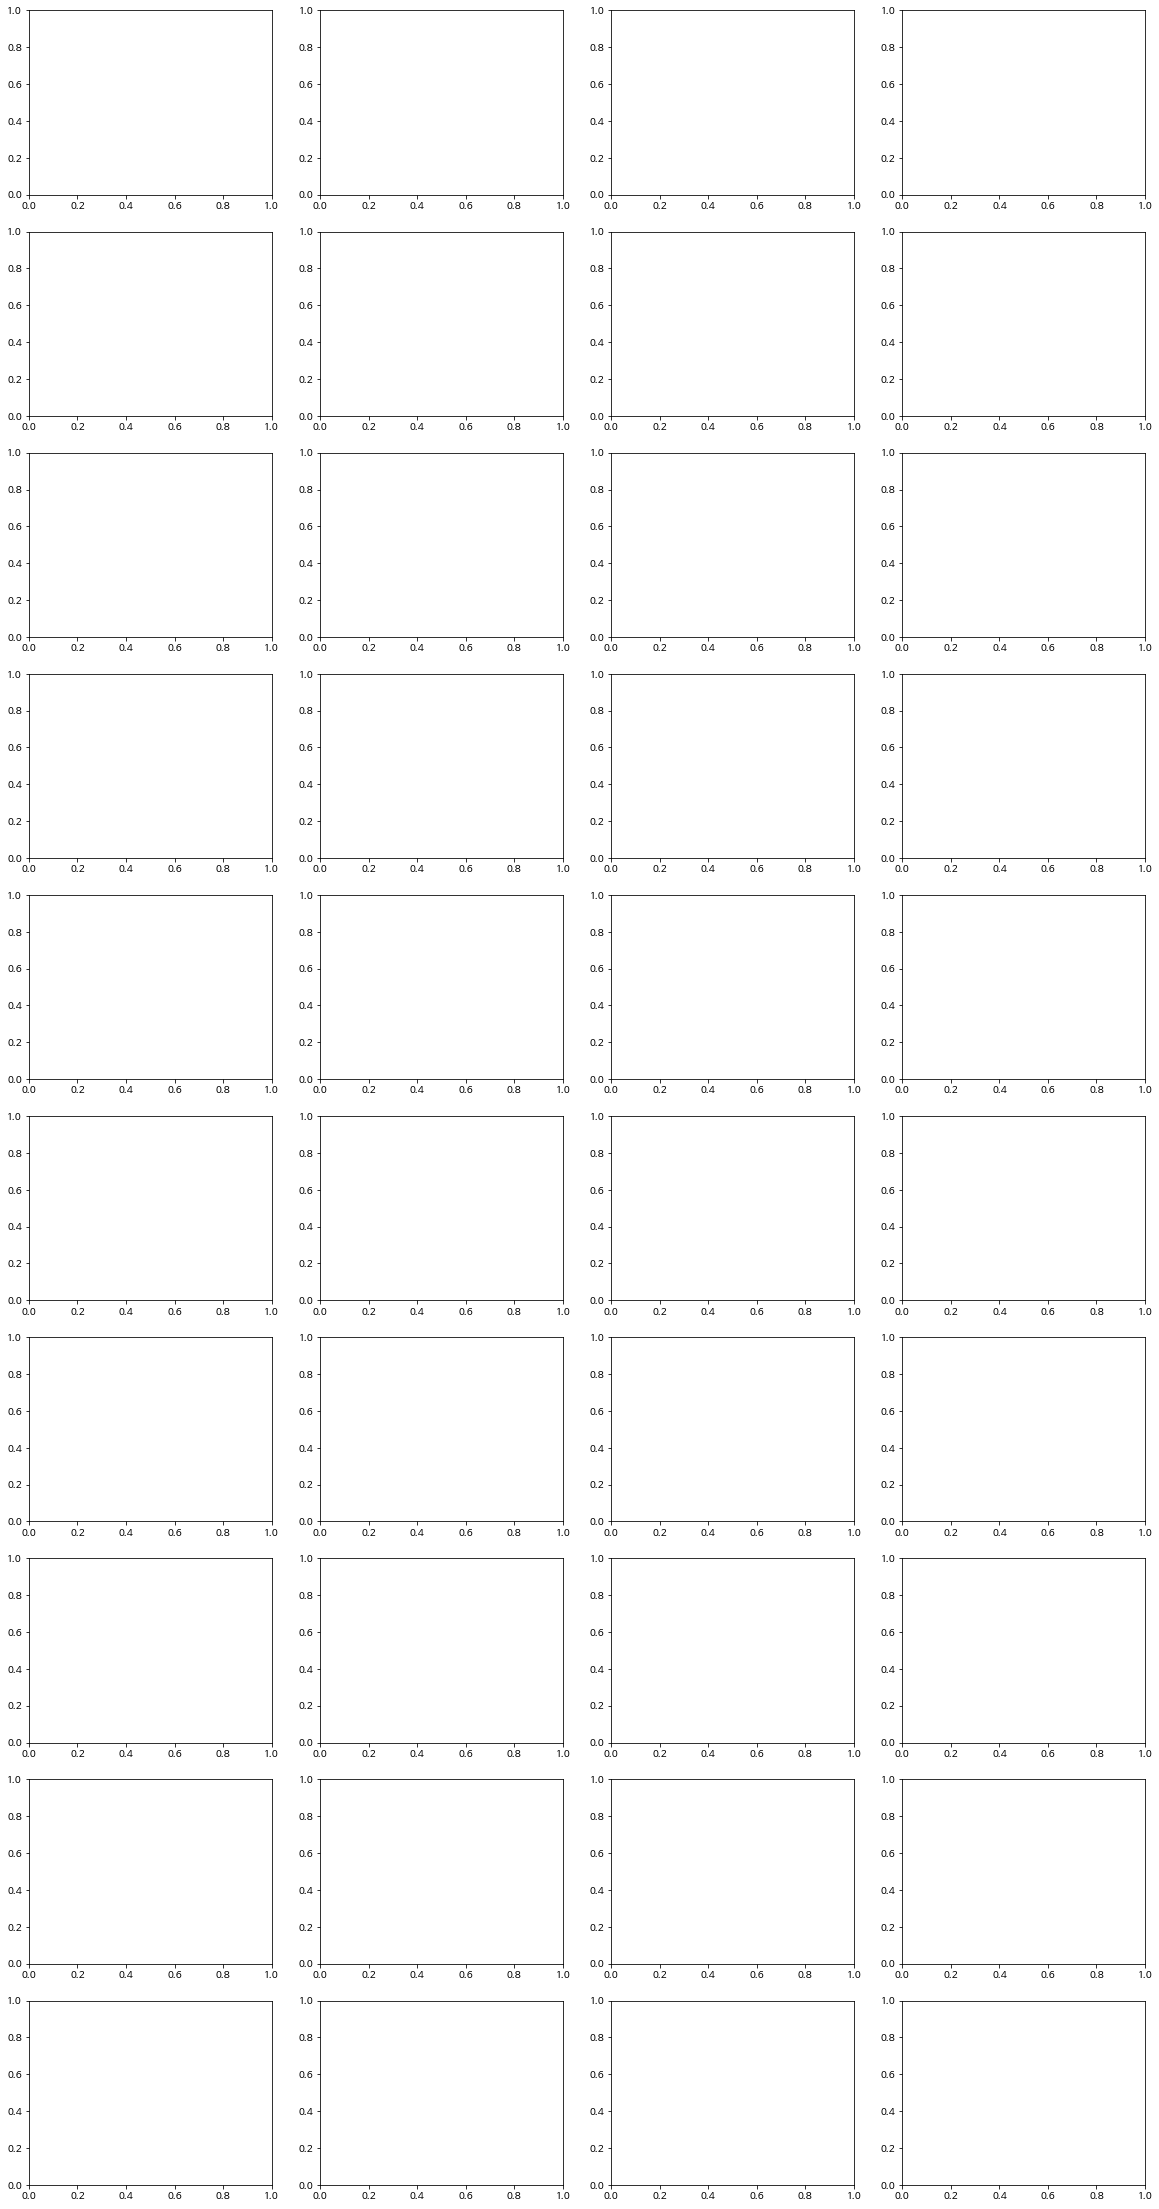

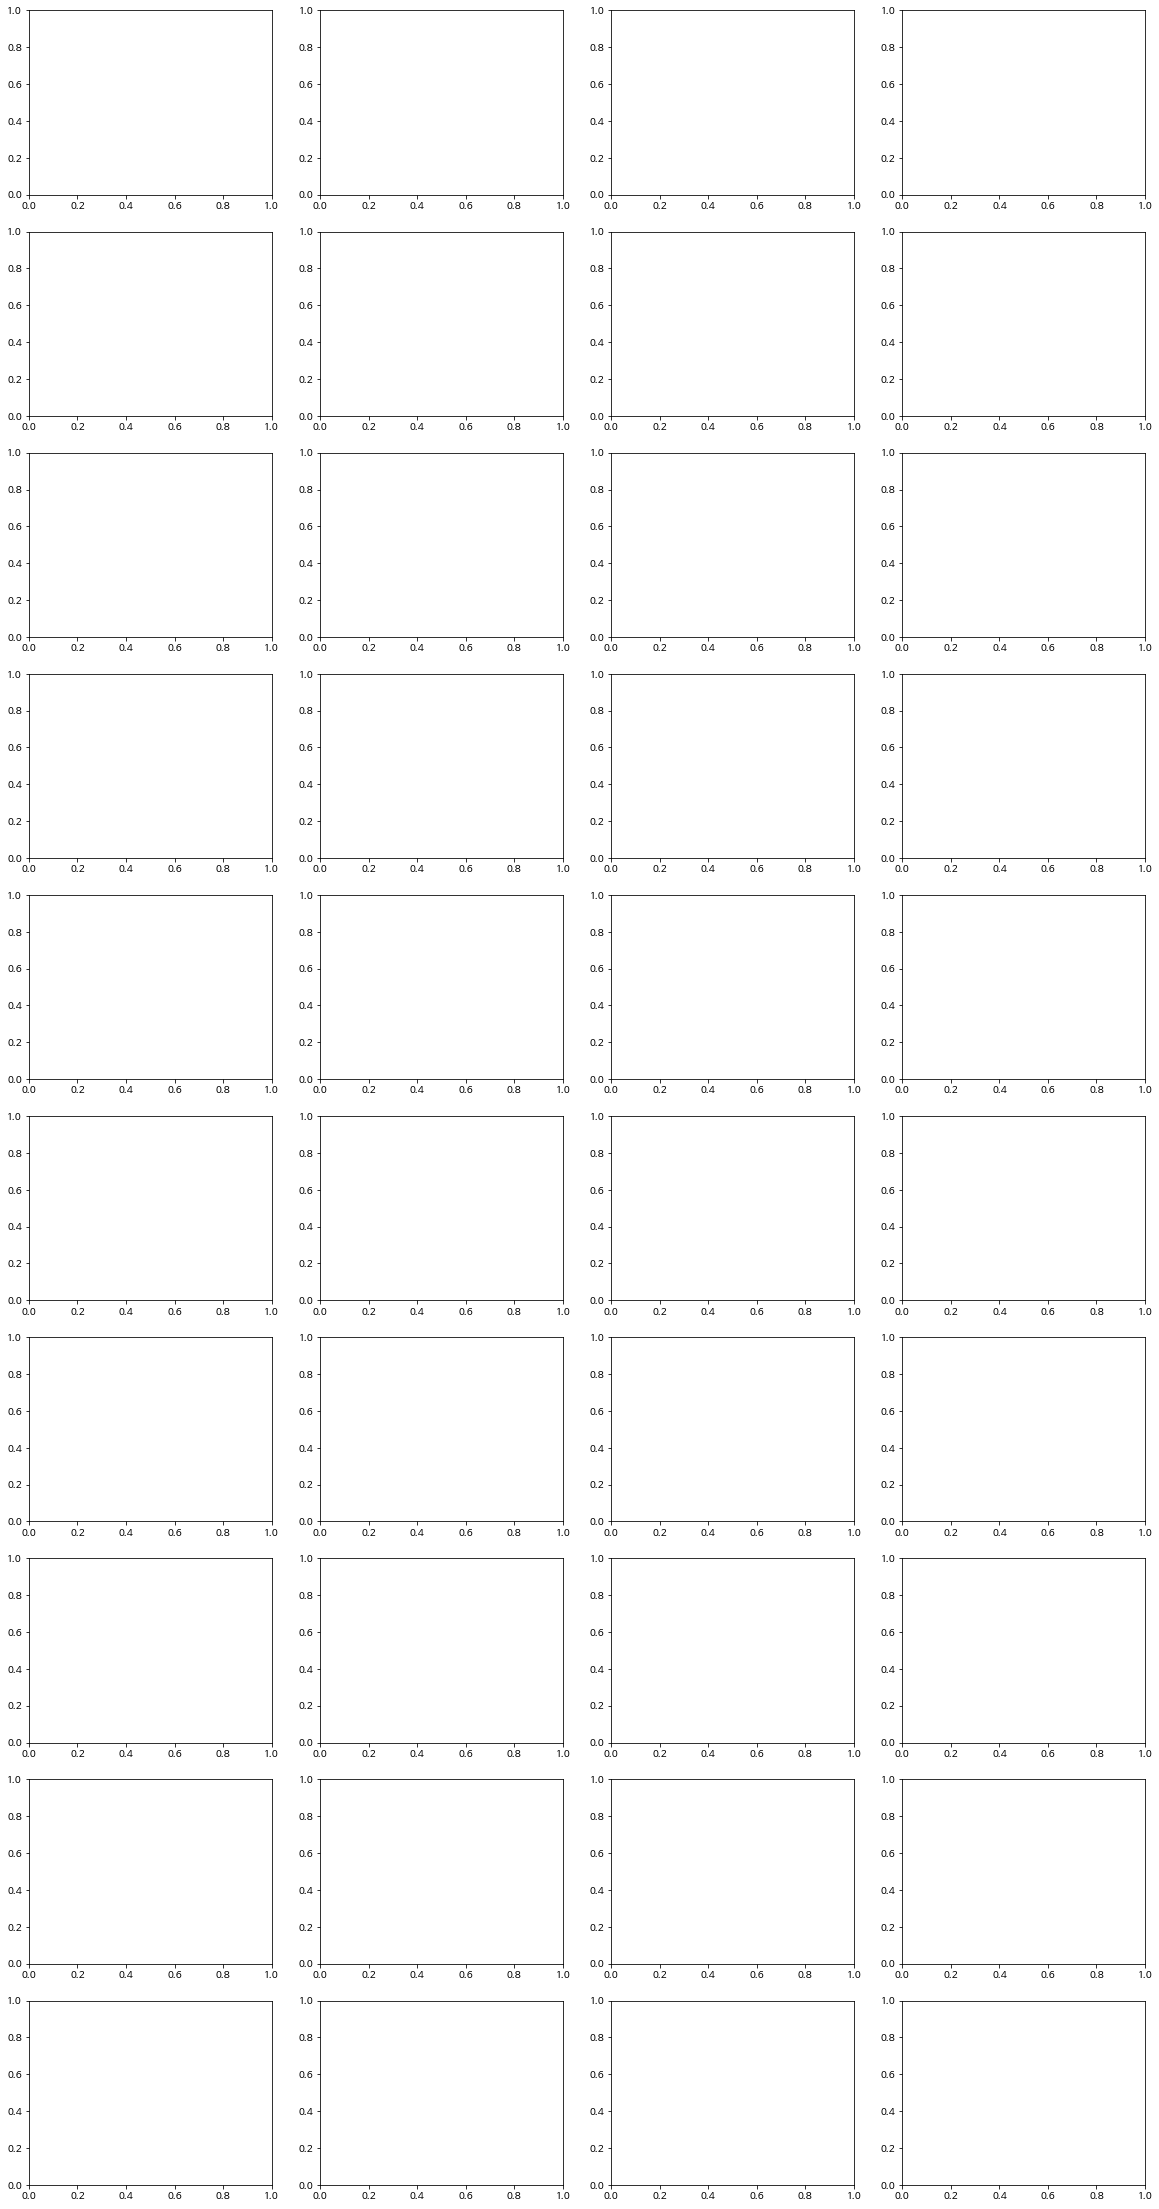

In [ ]:
img_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/data/kaggle_data'
load_dataset(img_dir, img_present_num=40, column_len=4)

### 데이터셋 저장 형식 변형
- 방법1로 저장되어있는 데이터를 불러온다. 
- 28x28 크기로 resize 한다.
- 이미지를 인덱스 순으로 저장한다.
- 인덱스와 폴더의 클래스명을 하나로 묶어서 csv 혹은 txt 파일로 저장한다.

In [ ]:
# 폴더 생성 함수
def make_dir(dir):
    if os.path.isdir(dir):
        print("경로가 이미 존재합니다.")
    else:
        os.makedirs(dir)
        print("폴더를 생성하였습니다.")

# 이미지 변환 및 label 데이터 저장 함수
def make_dataset(raw_data_dir,
                 image_dir,
                 label_dir,
                 img_size=28
):
    # 폴더 생성
    make_dir(image_dir)
    make_dir(label_dir)

    img_paths, labels = [], []
    label_names = os.listdir(raw_data_dir)
    for label_name in label_names:
        path = os.path.join(raw_data_dir, label_name, "*.png")
        img_paths.extend(glob(path))

    # 이미지 resize
    for idx, img_path in enumerate(tqdm_notebook(img_paths)):
        image = Image.open(img_path)
        image = image.resize((img_size,img_size), Image.ANTIALIAS)
        image = image.convert("RGB")
        path = os.path.join(image_dir, str(idx)+".JPEG")
        image.save(path)
        # 레이블 값을 변수에 저장
        labels.append(img_path.split("\\")[-2])

    # csv 타입의 label 데이터 생성(이게 좀 더 좋은 듯 함.)
    data = {"idx": list(range(len(labels))),
            "label": labels}
    dataset_df = pd.DataFrame(data=data)
    dataset_df.to_csv(os.path.join(label_dir, "label.csv"))

    # # txt 타입의 label 데이터 생성
    # with open(os.path.join(label_dir, "label.txt"), "w") as f:
    #     for idx, label in enumerate(labels):
    #         f.write(str(idx) + ", " + label + "\n")

In [ ]:
# # 데이터 경로 설정
# kaggle_img_dir = r"G:\내 드라이브\0. 인공지능 학습\아이펠 대전 3기\2. Exploration 수업\코드\5강\data\kaggle_data"
# RSP_img_dir = r"G:\내 드라이브\0. 인공지능 학습\아이펠 대전 3기\2. Exploration 수업\코드\5강\dataset\image"
# RSP_label_dir = r"G:\내 드라이브\0. 인공지능 학습\아이펠 대전 3기\2. Exploration 수업\코드\5강\dataset\label"

# 구글 코랩일 경우
kaggle_img_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/data/kaggle_data'
RSP_img_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/dataset/image'
RSP_label_dir = '/gdrive/MyDrive/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/5강/dataset/label'

In [ ]:
make_dataset(
    kaggle_img_dir,
    RSP_img_dir, 
    RSP_label_dir,
    img_size=28
)

### Train / Valid / Test 데이터셋 분리 및 전처리
- 입력 데이터의 범위를 0 ~ 255 -> 0 ~ 1로 정규화
- Train / Valid / Test 데이터셋의 비율은 6:2:2로 설정
- 클래스명 리스트 생성
- 클래스명에 따른 one-hot 인코딩 생성

In [21]:
csv_path = os.path.join(RSP_label_dir, "label.csv")
label_df = pd.read_csv(csv_path)

img_paths, label_names = [], []
for idx, label_name in zip(label_df.loc[:, "idx"], label_df.loc[:, "label"]):
    img_paths.append(os.path.join(RSP_img_dir, str(idx) + ".JPEG"))
    label_names.append(label_name)

classes = np.unique(label_names)
print("클래스명 :", np.unique(label_names))

labels = []
for label_name in label_df.loc[:, "label"]:
    label = np.argmax(np.array(classes == label_name, np.uint8)).tolist()
    one_hot = np.array(classes == label_name, np.uint8).tolist()
    # 이 부분 에러가 자꾸 나는데 numpy와 list에 대해서 알아보자
    one_hot.append(label)
    labels.append(one_hot)
# print(labels)

images = np.zeros((len(img_paths), 784, 3))
for idx, img_path in enumerate(tqdm_notebook(img_paths)):
    image = Image.open(img_path)
    image = np.array(image)
    images[idx] = image.reshape(1, 784, 3)

# 이미지 정보를 1로 정규화
images = images / 255.0

클래스명 : ['paper' 'rock' 'scissors']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2892 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
ratios = [.6, .2, .2]

train_cnt = int(images.shape[0] * ratios[0])
valid_cnt = int(images.shape[0] * ratios[1])
test_cnt = images.shape[0] - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train : %d 개 / Valid : %d 개 / Test : %d 개" % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(images.shape[0])

x = torch.index_select(torch.Tensor(images), dim=0, index=indices)
y = torch.index_select(torch.Tensor(labels), dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())


In [ ]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 3),
    nn.LogSoftmax(dim=-1),
)

model

In [ ]:
crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [ ]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [ ]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [ ]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

In [ ]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [ ]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

In [ ]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

데이터 분리
모델 생성
훈련
평가

In [ ]:
# Rock Scissors Paper 데이터셋 로드 함수 생성
class RSPDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.labels = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        pass

In [ ]:

# with open(os.path.join(RSP_label_dir, "label.txt"), "r") as f:
#     lines = f.readlines()

#     idx, label = [], []
#     for line in lines:
#         idx.append(line.split(", ")[0].strip())
#         label.append(line.split(", ")[1].strip())

# print(idx[10], label[10])

10 paper


# 모델 생성
### 모델 설계
- 가장 기본적인 모델부터 검증을 시작하자.
- 

In [ ]:
# 이미지를 저장하자
# 28x28 이미지로 미리 변환해두자
# 데이터를 변환하면서 이름을 정하고 변수에 이름의 리스트를 저장해서 label 파일로 만들자
# 여러 데이터 레이블링 방법을 찾아보자.


# rock_dir = os.path.join(RSP_img_dir, "rock/*.*")
# print(rock_dir)
# a = glob(rock_dir)
# print(a)

In [ ]:
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.0).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

In [ ]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

model

In [ ]:
crit = nn.NLLLoss()

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [ ]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [ ]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [ ]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [ ]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # valid 테스트
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print("Epoch %d: train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e" % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)


In [ ]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [ ]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4f" % test_loss)

In [ ]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print("Accuracy: %.4f" % (correct_cnt / total_cnt))

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
    index=["true_%d" % i for i in range(10)],
    columns=["pred_%d" % i for i in range(10)]
)